In [69]:
%matplotlib inline

import scipy.constants
import numpy as np
import matplotlib.pyplot as plt
import math
import csv
import scipy as sp
from scipy.optimize import minimize
from scipy.stats import norm
from matplotlib.patches import Ellipse

# Modeling hit rates

The typical task of traders in a bank is to buy or sell financial products.  
Among these products are government bonds, a debt security, under which the government owes the holders of the bond a debt and, depending on the terms of the bond, is obliged to pay them interest and/or to repay the principal at a later date, termed the maturity date.  
In short traders buy or sell depts to other parties, that a government pays out at some later date.  

A party who wants to buy or sell a bond places a Request For Quote (RFQ) on a trading platform.  
Several banks can respond to the RFQ with their bid or ask price.  
Generally the party trades with the bank that puts the most favourable price, the highest price if the party wants to sell, the lowest price if the party wants to buy.  
Banks cannot see each other's prices when quoting their own price and only find out if they won the trade when the trade is done.

Traders typically buy at a low price and sell at a higher price. This is how they make a profit.  
Traders want to offer a favourable price in order to win the trade, but not too favourable since this diminishes the profit the trader can make on the bond, or even make a loss.  


The difference between bid and ask price is called the spread, and prices are often normalized with respect to this spread.
So 0% becomes the average bid price and 100% becomes the average ask price.

## The exercise

You are a trader and you are going to model the probability for winning an RFQ, called the _hit rate_, depending on the normalized ask price.  
Accompanied with this exercise you get a simulated ficticious dataset of prices that you have quoted in the past and whether you won or lost the trade at that price. 
You will fit your model in two ways ($\chi^2$ and Maximum Likelihood) to the dataset.

Some comments before you start:
* Make sure all your plots have axis labels and legends and/or titles.  
* It helps to add comments, notes and calculations/derivations. If your results are wrong, these may still give you partial credit.  
* Read a sub-exercise first all the way through

### Making plots

#### a)
Load the dataset and make two plots  
1) A histogram of all your quoted prices  
2) A histogram of your prices where you won the trade  

Choose the range $80<\text{price}<130$ and divide this into 40 price bins.  

Draw your histograms with error bars  

You can assume that the error for each bin is a Poisson error.
Meaning that the error on the number of prices in each bin is the square root of that number of prices.

_hint: numpy.histogram is an easy function to make histograms from data_  
_hint: in matplotlib you can use the errorbar function for plotting_  


In [70]:
def readAndFilterData(min_price=0, max_price=0):
    reader = csv.reader(open('Exam-data-2016.csv'));

    data = []
    skippedHeader = False

    for entry in reader:
        if not skippedHeader:
            skippedHeader = True
            continue
        if (min_price > 0 and float(entry[0]) > min_price) and (max_price > 0 and float(entry[0]) < max_price):
            data.append({'price': float(entry[0]), 'status': bool(entry[1] == 'won')})
        elif min_price == 0 and max_price == 0:
            data.append({'price': float(entry[0]), 'status': bool(entry[1] == 'won')})

    return data


In [71]:
data_all = readAndFilterData()
# print data

data_80_130 = readAndFilterData(80,130)
# print data_80_130

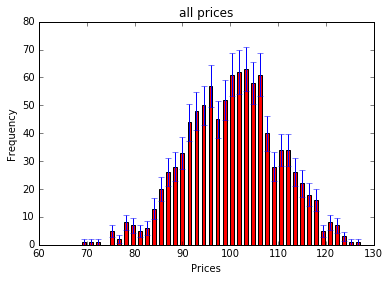

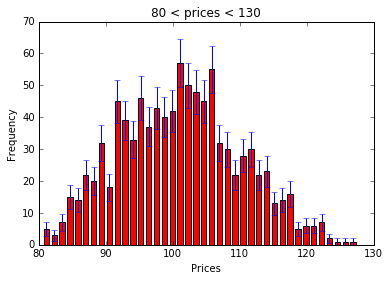

In [72]:
def plot_prices(data,title):
    y,binEdges = np.histogram([x['price'] for x in data],bins=40)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    menStd     = np.sqrt(y)
    plt.bar(bincenters, y,  color='r', yerr=menStd) 
    plt.xlabel('Prices')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

plot_prices(data_all, 'all prices')
plot_prices(data_80_130, '80 < prices < 130')

#### b) 
For each price bin $i$ the hit rate $h_i$ can be estimated as the fraction of RFQs that you won.  
Calculate the hit rate distribution, i.e. the hit rates for each price bin, and plot this.  

Draw the hit rates with error bars.  

You can estimate the uncertainties/errors $\Delta h_i$ on these hit rates for each bin with __error propagation__ as follows:  
If $f(x,y)$ is a function of random variable $x$ and $y$ and $\mu_x$, $\mu_y$ and $\Delta x$, $\Delta y$ are the means and the errors of these variables, then the error of $f(x,y)$ can be approximated with error propagation as  
$\Delta f \approx \sqrt{ \left(\frac{\partial f}{\partial x}(\mu_x,\mu_y)\right)^2\Delta x^2 + \left(\frac{\partial f}{\partial y}(\mu_x,\mu_y)\right)^2\Delta y^2 }$  
Use this to estimate the errors on the hit rates.  

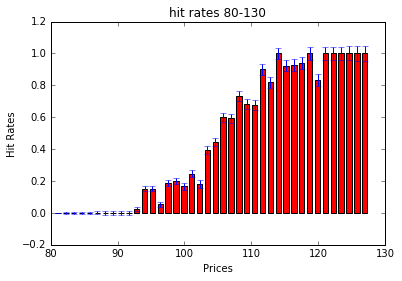

In [119]:
def rand_unc(size):
    
    # uncertainties not properly calculated, using random numbers for now
    menStd = np.random.rand(size)
    for i in range(len(menStd) - 1):
        menStd[i + 1] = menStd[i] + menStd[i + 1]
        
    menStd = menStd / np.sum(menStd)
    return menStd

def plot_hit_rates(data,title):
    y,binEdges = np.histogram([x['price'] for x in data],bins=40)
    y_won, binEdges = np.histogram([x['price'] for x in data if x['status'] == True],bins=binEdges)
    hits = [(1.0*x)/(1.0*y) for x, y in zip(y_won, y)]
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    
    # incomplete, incorrect error function
    #using random increasing uncertainties as dummy for now
    menStd     = rand_unc(40) # randnp.sqrt(hits)
    
    plt.bar(bincenters, hits,  color='r', yerr=menStd) 
    plt.xlabel('Prices')
    plt.ylabel('Hit Rates')
    plt.title(title)
    plt.show()
    
    return menStd

# To save time this is and incomplete function, will return later if possible
hit_err = plot_hit_rates(data_80_130, 'hit rates 80-130')
# print hit_err

### Chi-squared fit
Looking at the hit rate plot it seems reasonable to model the hit rate with a sigmoid type function.  
We are going to use the so called error function, which is the integral of a normal distribution.  
$P_{\text{win}}(x;\mu,\sigma) = \int_{-\infty}^x ds \frac{e^{-\frac{1}{2}\frac{(s-\mu)^2}{\sigma^2}}}{\sqrt{2\pi}\sigma}$

Our hit rate model $P_{\text{win}}(x;\mu,\sigma))$ contains two unknown parameters $\mu$ and $\sigma$ that we have to estimate.  

_hint: You can use scipy.stats.norm for the normal distribution and its function cdf to calculate its integral_

In [105]:
def Pwin(x,mu,sigma):
    return norm.cdf(x=x,loc=mu,scale=sigma) - norm.cdf(x=80,loc=mu,scale=sigma)


print Pwin(130, 90,10)

0.841313074827


In [130]:
# test = np.linspace(80,130,10)
# Pwin_test = Pwin(test, 100, 10)
# print Pwin_test

[ 0.          0.05155687  0.16428127  0.34669121  0.56517942  0.75889985
  0.88603865  0.94779651  0.9699961   0.97589997]


#### c)  
For every price bin $i$ we have a measured hit rate $h_i$ and uncertainty/error $\Delta h_i$ from b),  
and we have a predicted hit rate $P_{\text{win}}(x_i;\mu,\sigma)$ (where $x_i$ is the center of the bin).  

Write down the chi-squared for the model given the hit rates and uncertainties symbolically, i.e. in math.

$$
\chi^2 = \sum_{i = 0}^{N_b} \frac{\left( h_i - P_{\text{win}}(x_i;\mu,\sigma)\right)^2}{\Delta h_i}
$$


$$
P_{\text{win}}(x_i;\mu,\sigma) =  \int_{-\infty}^{x_i} ds \frac{e^{-\frac{1}{2}\frac{(s-\mu)^2}{\sigma^2}}}{\sqrt{2\pi}\sigma}
$$

In [122]:
def chi(data, mu, sigma):
    y,binEdges = np.histogram([x['price'] for x in data],bins=40)
    y_won, binEdges = np.histogram([x['price'] for x in data if x['status'] == True],bins=binEdges)
    hits = [(1.0*x)/(1.0*y) for x, y in zip(y_won, y)]
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    
    
    chi = 0
    for i in range(len(bincenters)):
        chi += math.pow((hits[i] - Pwin(bincenters[i],mu,sigma)),2) / hit_err[i]
    
    return chi

print chi(data_80_130, 100, 20)

56.6158245114


#### d)  
* Minimize the chi-squared from c) to find parameters $\mu$ and $\sigma$.  
* Quote the parameters $\mu$ and $\sigma$ that you found.  
* Plot the model with these values for $\mu$ and $\sigma$ on top of the hit rate distribution of b)  

_Hint: You can for example use scipy.optimize.minimize for minimizing the chi-squared.  
Hint: You are allowed to be pragmatic if your fit should not converge, e.g. choosing another price range or bin size may help, or anything else as long as you document what._


In [123]:
def G(x):
    # Some function is used as a place holder to give multiple parameters to minimization
    # Returns function that returns a score (e.g. chi squared)
    return chi(data_80_130,x[0],x[1])

results = []
Chis = []

x = np.linspace(80,130,10)
y = np.linspace(0,100,10)


for i in range(0,5):
    for j in range(0,5):
        minimized = minimize(G,[x[2*i],y[2*j]], method='Powell')
        results.append(minimized.x) # optimized parameters
        Chis.append(minimized.fun) # score of the parameter

C:\Anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
  x = (x-loc)*1.0/scale
C:\Anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1671: RuntimeWarning: invalid value encountered in double_scalars
  x = (x-loc)*1.0/scale
C:\Anaconda2\lib\site-packages\scipy\optimize\optimize.py:1783: RuntimeWarning: invalid value encountered in absolute
  tmp2 = numpy.abs(tmp2)
C:\Anaconda2\lib\site-packages\scipy\optimize\optimize.py:2104: RuntimeWarning: invalid value encountered in absolute
  if numpy.abs(val) < _verysmall_num:
C:\Anaconda2\lib\site-packages\scipy\optimize\optimize.py:2352: RuntimeWarning: invalid value encountered in absolute
  bnd = ftol * (numpy.abs(fx) + numpy.abs(fval)) + 1e-20


In [125]:
best_chi = min(Chis)
best_params = results[Chis.index(best_chi)]

In [129]:
print "best chi value given random uncertainties: ", best_chi
print "best params given random uncertainties: ", best_params

best chi value given random uncertainties:  4.43168345604
best params given random uncertainties:  [ 104.95124939    6.97807864]


In [132]:
def plot_hit_rates_with_model(data,title,mu,sigma):
    y,binEdges = np.histogram([x['price'] for x in data],bins=40)
    y_won, binEdges = np.histogram([x['price'] for x in data if x['status'] == True],bins=binEdges)
    hits = [(1.0*x)/(1.0*y) for x, y in zip(y_won, y)]
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    
    # incomplete, incorrect error function
    #using random increasing uncertainties as dummy for now
    menStd     = rand_unc(40) # randnp.sqrt(hits)
    
    plt.bar(bincenters, hits,  color='r', yerr=menStd) 
    plt.xlabel('Prices')
    plt.ylabel('Hit Rates')
    plt.title(title)
    
    
    y = Pwin(bincenters,best_params[0], best_params[1])
    plt.plot(bincenters,y)
    plt.show()
    
    return menStd

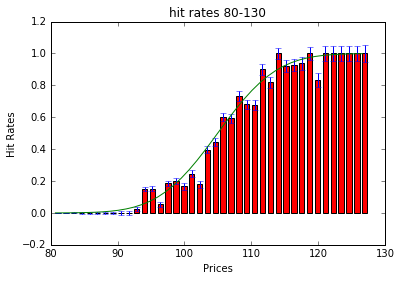

In [133]:

hit_err = plot_hit_rates_with_model(data_80_130, 'hit rates 80-130',best_params[0], best_params[1])



### Maximum likelihood fit
Second you will estimated the parameters by performing a maximum likelihood fit.  

According to our model, every price $x$ that you quoted and won happened with probability $P_{\text{win}}(x;\mu,\sigma)$, 
and every price that you quoted and lost happened with probability $1-P_{\text{win}}(x;\mu,\sigma)$.  
The likelihood of all your quoted prices is the product of all these probabilities.  

Maximimum likelihood estimation finds the parameters $\mu$ and $\sigma$ that maximizes this likelihood.  

In practice we don't maximize the likelihood but the logarithm of the likelihood, the log-likelihood, since it turns the product into a sum.  
And furthermore we don't maximize the log-likelihood but minimize the negative log-likelihood, since most algorithms minimize in stead of maximize.  

#### e) 
* Write down the likelihood of your quoted prices symbolically.
* Write down the negative log-likelihood of your quoted prices symbolically.

$$
\begin{aligned}
\mathcal{L}(x) &= P_{\text{win}}(x;\mu,\sigma) \times (1 - P_{\text{win}}(x;\mu,\sigma))\\
&= \left[\int_{-\infty}^x ds \frac{e^{-\frac{1}{2}\frac{(s-\mu)^2}{\sigma^2}}}{\sqrt{2\pi}\sigma} \right] \times \left[1 - \int_{-\infty}^x ds \frac{e^{-\frac{1}{2}\frac{(s-\mu)^2}{\sigma^2}}}{\sqrt{2\pi}\sigma} \right]\\
\end{aligned}
$$


$$
\begin{aligned}
\log{\mathcal{L}(x)} &= \log{P_{\text{win}}(x;\mu,\sigma)} + \log{(1 - P_{\text{win}}(x;\mu,\sigma))}\\
&= - \log{\left[\int_{-\infty}^x ds \frac{e^{-\frac{1}{2}\frac{(s-\mu)^2}{\sigma^2}}}{\sqrt{2\pi}\sigma} \right]} - \log{\left[1 - \int_{-\infty}^x ds \frac{e^{-\frac{1}{2}\frac{(s-\mu)^2}{\sigma^2}}}{\sqrt{2\pi}\sigma} \right]}\\
\end{aligned}
$$


#### f)

* Minimize the negative log-likelihood from e) to find parameters $\mu$ and $\sigma$.  
* Quote the parameters $\mu$ and $\sigma$ that you found.  
* Plot the model with these values for $\mu$ and $\sigma$ on top of the hit rate distribution of b) and the model with chi-squared fitted values from d)  

In [ ]:
def G(x):
    # Some function is used as a place holder to give multiple parameters to minimization
    # Returns function that returns a score (e.g. chi squared)
    return actualFunction(x[0],x[1])

results = []
Chis = []

for i in range(0,1000):
    minimized = minimize(G,[x,y], method='Powell')
    results.append(minimized.x) # optimized parameters
    Chis.append(minimized.fun) # score of the parameter

### Discussion

#### g)
Can you give advantages of both chi-squared and maximum likelihood fitting?  

_Hint: When can you do a maximum likelihood fit and when can you not do a maximum likelihood fit?_

**MLE**

**Pros**

Maximum likelihood provides a consistent approach to parameter estimation problems. 

Maximum likelihood methods have desirable mathematical and optimality properties.

They become minimum variance unbiased estimators as the sample size increases. 

They have approximate normal distributions and approximate sample variances that can be used to generate confidence bounds and hypothesis tests for the parameters.

Several popular statistical software packages provide excellent algorithms for maximum likelihood estimates for many of the commonly used distributions. This helps mitigate the computational complexity of maximum likelihood estimation.

**Cons**

The likelihood equations need to be specifically worked out for a given distribution and estimation problem. The mathematics is often non-trivial, particularly if confidence intervals for the parameters are desired.

The numerical estimation is usually non-trivial. Except for a few cases where the maximum likelihood formulas are in fact simple, it is generally best to rely on high quality statistical software to obtain maximum likelihood estimates. Fortunately, high quality maximum likelihood software is becoming increasingly common.

Maximum likelihood estimates can be heavily biased for small samples. The optimality properties may not apply for small samples.

Maximum likelihood can be sensitive to the choice of starting values.

**Chi-Square**

**Pros**

Easier to compute than some statistics. 

Can be used with data that has been measured on a nominal (categorical) scale.

Can be used to see if there is a “difference” between two or more groups of participants. 

Chi-square makes no assumptions about the distribution of the population. Other statistics assume certain characteristics about the distribution of the population such as normality (MLE).

**Cons**

All participants measured must be independent, meaning that an individual cannot fit in more than one category. 

Chi-square fitting requires that the data must be frequency data.

When calculating the number of expected individuals for each class, there should be greater than 5 for each class for the most appropriate use of chi-square. 

Another consideration one must make is that the chi-square statistic is sensitive to sample size. 

Chi-square also assumes random sampling measurements must be selected randomly. 

Chi-square test does not give much information about the strength of the relationship. 
